In [1]:
import os

os.environ["KAGGLE_USERNAME"] = "ravikanttyagi001"
os.environ["KAGGLE_KEY"] = "6d26f78448240c444f290efd0f2fae64"

!kaggle datasets download prasoonkottarathil/face-mask-lite-dataset

Dataset URL: https://www.kaggle.com/datasets/prasoonkottarathil/face-mask-lite-dataset
License(s): CC-BY-SA-4.0
100% 23.3G/23.3G [03:04<00:00, 275MB/s]
100% 23.3G/23.3G [03:04<00:00, 136MB/s]


In [2]:
!unzip face-mask-lite-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: without_mask/seed5000.png  
  inflating: without_mask/seed5001.png  
  inflating: without_mask/seed5002.png  
  inflating: without_mask/seed5003.png  
  inflating: without_mask/seed5004.png  
  inflating: without_mask/seed5005.png  
  inflating: without_mask/seed5006.png  
  inflating: without_mask/seed5007.png  
  inflating: without_mask/seed5008.png  
  inflating: without_mask/seed5009.png  
  inflating: without_mask/seed5010.png  
  inflating: without_mask/seed5011.png  
  inflating: without_mask/seed5012.png  
  inflating: without_mask/seed5013.png  
  inflating: without_mask/seed5014.png  
  inflating: without_mask/seed5015.png  
  inflating: without_mask/seed5016.png  
  inflating: without_mask/seed5017.png  
  inflating: without_mask/seed5018.png  
  inflating: without_mask/seed5019.png  
  inflating: without_mask/seed5020.png  
  inflating: without_mask/seed5021.png  
  inflating: without_mask/seed5022.png  
  infl

In [3]:
mask_images = os.listdir("with_mask")
for i in range(len(mask_images)):
  os.remove("with_mask" + "/" + mask_images[i])

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [5]:
ROOT_DIR = "without_mask"
face_images_path = os.listdir(ROOT_DIR)
faces_data = []
SIZE = WIDTH, HEIGHT = 128, 128
# tqdm - to show progress bar for our loop
for i in tqdm(range(3000)):
  img_path = ROOT_DIR + "/" + face_images_path[i]
  img = cv2.imread(img_path)
  # because opencv reads image in BGR format, so we convert into RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # resize image because all the images might be in different size
  img = cv2.resize(img, (WIDTH, HEIGHT))
  # normalization of image
  img = img / 255.0
  faces_data.append(img)

100%|██████████| 3000/3000 [02:36<00:00, 19.23it/s]


In [6]:
faces_array = np.asarray(faces_data)

In [7]:
faces_array.shape

(3000, 128, 128, 3)

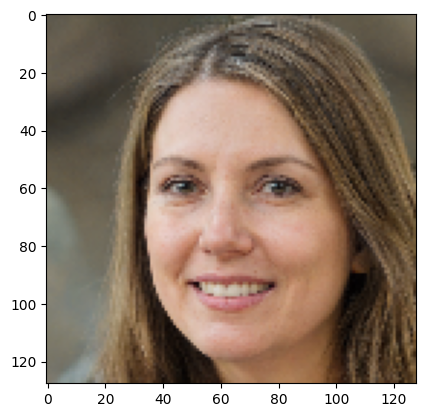

In [8]:
plt.imshow(faces_array[0])

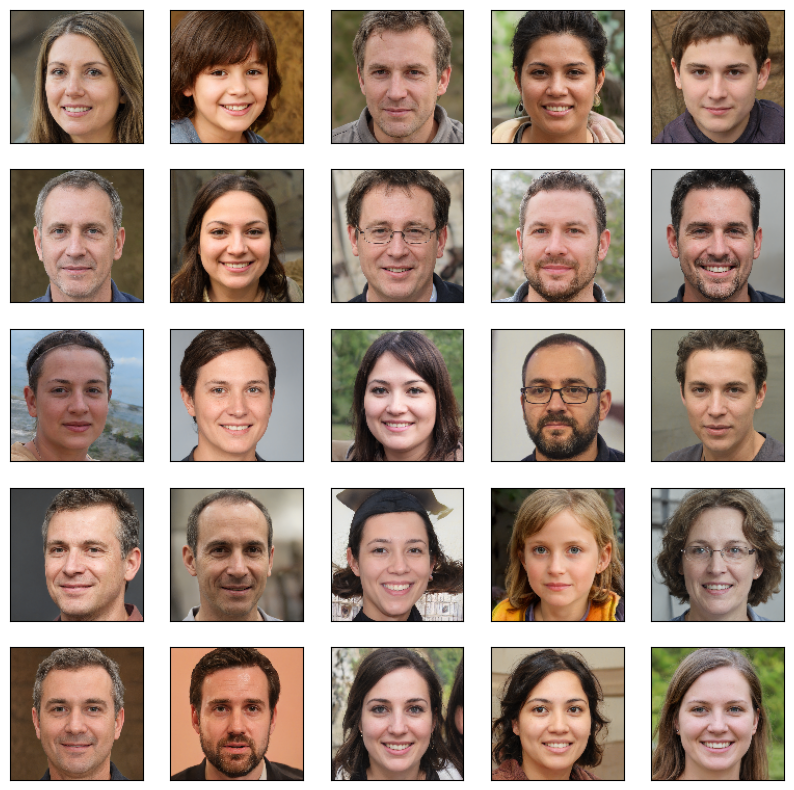

In [9]:
# plot 25 images on 1 graph
row, col = 5, 5
# size of figure
plt.figure(figsize=(10,10))
for i in range(row * col):
  plt.subplot(row, col, i+1)
  plt.imshow(faces_array[i])
  plt.xticks([])
  plt.yticks([])

In [13]:
noise_dim = 100
def Generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(128*128*3, input_shape=(noise_dim,)))
  model.add(layers.Reshape((128,128,3)))
  # Downsampling
  model.add(layers.Conv2D(128, 4, strides=1, padding="same"))
  model.add(layers.Conv2D(128, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(256, 4, strides=1, padding="same"))
  model.add(layers.Conv2D(256, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(512, 4, strides=1, padding="same"))
  model.add(layers.Conv2D(512, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(512, 4, strides=1, padding="same"))
  model.add(layers.Conv2DTranspose(512, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(256, 4, strides=1, padding="same"))
  model.add(layers.Conv2DTranspose(256, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding="same"))
  model.add(layers.Conv2DTranspose(128, 4, strides=1, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(3, 4, strides=1, padding="same"))
  return model


In [14]:
generator = Generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 49152)             4964352   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6272      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262272    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       524544    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)      

In [15]:
def Discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Input((WIDTH, HEIGHT, 3)))
  # Downsampling
  model.add(layers.Conv2D(128, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(128, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(256, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(256, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(512, 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation="sigmoid"))
  return model

In [16]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       6272      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 256)       524544    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)        

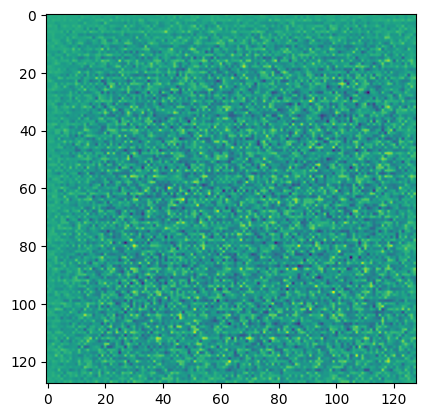

In [17]:
noise = np.random.normal(-1, 1, (1,100))
img = generator(noise)
plt.imshow(img[0, :, :, 0])
plt.show()

In [36]:
optimizer = tf.keras.optimizers.legacy.RMSprop()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  real_loss = cross_entropy(tf.ones_like(real_output), fake_output)
  return fake_loss + real_loss

In [40]:
# all_trainable_variables = generator.trainable_variables + discriminator.trainable_variables

# Rebuild the optimizer with all trainable variables
# optimizer.build(all_trainable_variables)

def train_steps(real_images):
  noise = np.random.normal(0, 1, (batch_size, noise_dim))
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_images = generator(noise)
    fake_output = discriminator(generated_images)
    real_output = discriminator(real_images)

    gen_loss = generator_loss(fake_output)
    dis_loss = discriminator_loss(real_output, fake_output)

  gradient_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_of_dis = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
  optimizer.apply_gradients(zip(gradient_of_gen, generator.trainable_variables))
  optimizer.apply_gradients(zip(gradient_of_dis, discriminator.trainable_variables))

  loss = {
      "gen_loss" : gen_loss,
      "dis_loss" : dis_loss
  }

  return loss

In [41]:
def plot_gen_images(grid=5, epochs=0):
  plt.figure(figsize=(10,10))
  for i in range(grid*grid):
    if epochs % 10 == 0:
      print(f"Images Generated at {epochs} Epoch")
      plt.subplot(grid, grid, i+1)
      noise = np.random.normal(0,1,(1,noise_dim))
      img = generator(noise)
      plt.imshow(img[0, :, :, 0])
      plt.xticks([])
      plt.yticks([])
      plt.gird()

In [42]:
def train(epochs, dataset):
  for epoch in range(epochs):
    print(f"Epoch : {epoch}")
    for i in range(0, len(dataset), batch_size):  # Iterate in batches
      images = dataset[i : i + batch_size]  # Extract a batch
      loss = train_steps(images)
    print(f"Gen Loss : {loss['gen_loss']}, Dis Loss : {loss['dis_loss']}")

In [43]:
epochs = 10
batch_size = 32
train(epochs, faces_array)

Epoch : 0


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


ValueError: `logits` and `labels` must have the same shape, received ((32, 1) vs (24, 1)).